### Imports and listed versions

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product

In [ ]:
print(f'tensorflow=={tf.__version__}')
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'matplotlib=={matplotlib.__version__}')

tensorflow==1.15.2
pandas==1.1.5
numpy==1.18.5
matplotlib==3.2.2


### Data sources

In [ ]:
url_sp500 = 'https://raw.githubusercontent.com/amir-souri/Improved-Stock-Market-Index-Prediction/main/S%26P500.csv'

In [ ]:
df = pd.read_csv(url_sp500, index_col='Date')

## Construct normalized sequences

"Each of the data segments was normalized by subtracting each price in the sequence by the first price in the sequence, then divide by the first price in the sequence. This form of normalization is called relative change."

In [ ]:
def relative_change_normalization(data):
  """
  df: pandas.DataFrame

  Returns df where each column is normalized by subtracting the first row of the
  column and then dividing by the first row of the column.
  """
  return data.apply(lambda x: (x - x[0]) / x[0])

In [ ]:
def make_sequences(timeseries, sequence_length, target, to_numpy=False):
  """
  timeseries: pandas.Series
  sequence_length: positive integer
  to_numpy: Bool (default=False)

  Returns pandas.DataFrame where each column is name is based on the first day
  of the sequence and holds sequence_length number of consecutive entries of
  timeseries which we call a sequence.
  If to_numpy is True, then convert pandas.DataFrame to numpy array of shape
  (timeseries.size - sequence_length + 1, sequence_length).
  """
  sequence_ix = [np.arange(i, i + sequence_length) for i in np.arange(timeseries.size - (sequence_length + target) + 1)]
  df = pd.DataFrame(columns=timeseries.index[:-(sequence_length+target)+1], 
                    data=np.array([timeseries[ix] for ix in sequence_ix]).T,
                    index=np.arange(sequence_length))
  df = relative_change_normalization(df)
  df.columns.rename('First day of sequence', inplace=True)
  df.index.rename('Day', inplace=True)

  target_values_norm = timeseries[: timeseries.size - (sequence_length + target -1)].values
  target_values = (timeseries[sequence_length + target -1 :] - target_values_norm) / target_values_norm

  if to_numpy:
    return df.to_numpy(dtype=np.float64).T.reshape(df.shape[1],sequence_length,1), target_values.to_numpy(dtype=np.float64).reshape(-1,1)
  else:
    return df, target_values

# Read and split the data

Train - 70%

Validation - 15%

Test - 15%

In [ ]:
X,y = make_sequences(df['Close'], 50, 7, to_numpy=True)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (2690, 50, 1)
y shape: (2690, 1)


In [ ]:
xx, x_test, yy, t_test = train_test_split(X,y,test_size=0.15, shuffle=True)
x_train, x_val, t_train, t_val = train_test_split(xx,yy,test_size = 0.1765, shuffle=True)

# Define hyper-parameters

In [ ]:
cnn_kernel_sizes = 9
n_cnn_filters = 128
hidden_units = 200
dropout_units = 0.25
n_epoch_grid = 50
n_epoch = 10000
log_every = 200

In [ ]:
weight_initializer = tf.initializers.glorot_uniform
bias_initializer = tf.zeros_initializer

# Utility functions

In [ ]:
def conv_1d(x, W, b, s=2):
    x = tf.nn.conv1d(input=x, filters=W, stride=s, padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool_1d(x, k=2):
    return tf.nn.max_pool1d(x, ksize=2, strides=2, padding='VALID')

# Input and output

In [ ]:
x = tf.placeholder(tf.float64, [None, 50, 1])
t = tf.placeholder(tf.float64, [None, 1])

# Define the model parameters

In [ ]:
Wc1 = tf.get_variable('Wc1', [cnn_kernel_sizes, 1, n_cnn_filters], initializer=weight_initializer, dtype=tf.float64) 
Wc2 = tf.get_variable('Wc2', [cnn_kernel_sizes, n_cnn_filters, n_cnn_filters*2], initializer=weight_initializer, dtype=tf.float64) 
Wc3 = tf.get_variable('Wc3', [cnn_kernel_sizes, n_cnn_filters*2, n_cnn_filters*4], initializer=weight_initializer, dtype=tf.float64)
Wd = tf.get_variable('Wd', [hidden_units*2, 1], initializer=weight_initializer, dtype=tf.float64)

Bc1 = tf.get_variable('Bc1', [n_cnn_filters], initializer=bias_initializer, dtype=tf.float64)
Bc2 = tf.get_variable('Bc2', [n_cnn_filters*2], initializer=bias_initializer, dtype=tf.float64)
Bc3 = tf.get_variable('Bc3', [n_cnn_filters*4], initializer=bias_initializer, dtype=tf.float64)
Bd = tf.get_variable('Bd', [1], initializer=bias_initializer, dtype=tf.float64)

# Construct model

In [ ]:
def construct_model(placeholder, model_name):
    Zc1 = tf.nn.relu(conv_1d(placeholder, Wc1, Bc1))
    Zc1 = maxpool_1d(Zc1)
    Zc2 = tf.nn.relu(conv_1d(Zc1, Wc2, Bc2))
    Zc2 = maxpool_1d(Zc2)
    Zc3 = tf.nn.relu(conv_1d(Zc2, Wc3, Bc3))
    Zc3 = maxpool_1d(Zc3)

    lstm_fw_cell_1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units) 
    lstm_bw_cell_1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
    with tf.variable_scope('lstm1'+model_name):
      outputs1, _= tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_1, lstm_bw_cell_1, Zc3, dtype='float64')

    conc1 = tf.concat(values=outputs1, axis=2)
    tf.nn.dropout(conc1, rate=dropout_units)

    lstm_fw_cell_2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
    lstm_bw_cell_2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
    with tf.variable_scope('lstm2'+model_name):
      outputs2, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_2, lstm_bw_cell_2, conc1, dtype='float64')

    conc2 = tf.concat(values=outputs2, axis=2)
    tf.nn.dropout(conc2, rate=dropout_units*2)

    fc = tf.reshape(conc2, [-1, hidden_units * 2])
    y = tf.add(tf.matmul(fc, Wd), Bd)
    return y

# Grid search

In [ ]:
l_rates = [1, 0.1, 0.01, 0.001, 0.0001]
rhos = [0.9, 0.95]
params = product(l_rates, rhos)
grid_loss_list = []
grid_model = construct_model(x, "_grid")
loss_grid = tf.losses.mean_squared_error(labels=t, predictions=grid_model)


for l_rate, rh in params:
    optimizer_grid = tf.train.AdadeltaOptimizer(learning_rate=l_rate, rho=rh).minimize(loss_grid)
    init = tf.global_variables_initializer()

    with tf.Session() as session:
        session.run(init)
        grid = []
        for epoch in range(n_epoch_grid):
            _, loss_value = session.run([optimizer_grid, loss_grid], feed_dict={x: x_train, t: t_train})
            val_loss_value = session.run(loss_grid, feed_dict={x: x_val, t: t_val})
            grid.append(val_loss_value)
            
    grid_loss_list.append(grid)
    print(f'{l_rate, rh} done')
print("Grid search done")
np.savetxt('grid_loss.csv', grid_loss_list, delimiter=',')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(1, 0.9) done
(1, 0.95) done
(0.1, 0.9) done
(0.1, 0.95) done
(0.01, 0.9) done
(0.01, 0.95) done
(0.001, 0.9) done
(0.001, 0.95) done
(0.0001, 0.9) done
(0.0001, 0.95) done
Grid search done


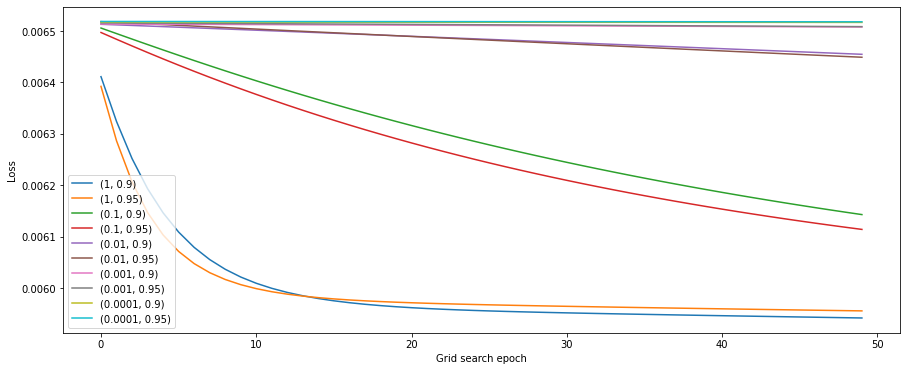

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

params = product(l_rates, rhos)
pars = []
for l_rate, rho in params:
  pars.append((l_rate, rho))
for i in range(10):
  ax.plot(range(len(grid_loss_list[i])), grid_loss_list[i], label=pars[i])
  ax.legend()
  ax.set_xlabel(r'Grid search epoch')
  ax.set_ylabel(r'Loss')

# Training

- Define hyperparameters after grid search manually
- Define the loss function and the optimizer operation

In [ ]:
learning_rate = 1
rho = 0.9

model = construct_model(x, "model")
loss = tf.losses.mean_squared_error(labels=t, predictions=model)
optimizer = tf.train.AdadeltaOptimizer(learning_rate, rho).minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

train_loss_list = []
val_loss_list = []
best_val_loss = np.float('inf')
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    for epoch in range(n_epoch+1):
        _, loss_value = session.run([optimizer, loss], feed_dict={x: x_train, t: t_train})
        val_loss_value = session.run(loss, feed_dict={x: x_val, t: t_val})

        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            saver.save(sess=session, save_path="./model")
        
        train_loss_list.append(loss_value)
        val_loss_list.append(val_loss_value)
        
        if epoch % log_every == 0:
            print("Epoch: ", epoch, "loss =", loss_value)

    np.savetxt('train_loss.csv', train_loss_list, delimiter=',')
    np.savetxt('validation_loss.csv', val_loss_list, delimiter=',')        
    print("Optimization done")

Epoch:  0 loss = 0.0059327325
Epoch:  200 loss = 0.0055467193
Epoch:  400 loss = 0.005269619
Epoch:  600 loss = 0.0035115033
Epoch:  800 loss = 0.002402366
Epoch:  1000 loss = 0.0021563154
Epoch:  1200 loss = 0.001979622
Epoch:  1400 loss = 0.0018580061
Epoch:  1600 loss = 0.001774044
Epoch:  1800 loss = 0.0017056097
Epoch:  2000 loss = 0.0016447868
Epoch:  2200 loss = 0.0015880562
Epoch:  2400 loss = 0.0015360035
Epoch:  2600 loss = 0.0014899422
Epoch:  2800 loss = 0.0014477761
Epoch:  3000 loss = 0.0014069144
Epoch:  3200 loss = 0.0013687288
Epoch:  3400 loss = 0.0013347289
Epoch:  3600 loss = 0.0013025634
Epoch:  3800 loss = 0.0012715687
Epoch:  4000 loss = 0.0012433388
Epoch:  4200 loss = 0.0012167159
Epoch:  4400 loss = 0.0011921719
Epoch:  4600 loss = 0.0011693216
Epoch:  4800 loss = 0.0011482739
Epoch:  5000 loss = 0.0011286751
Epoch:  5200 loss = 0.0011101917
Epoch:  5400 loss = 0.001093341
Epoch:  5600 loss = 0.0010778372
Epoch:  5800 loss = 0.0010630423
Epoch:  6000 loss = 0.

# Plot Training loss and Validation loss

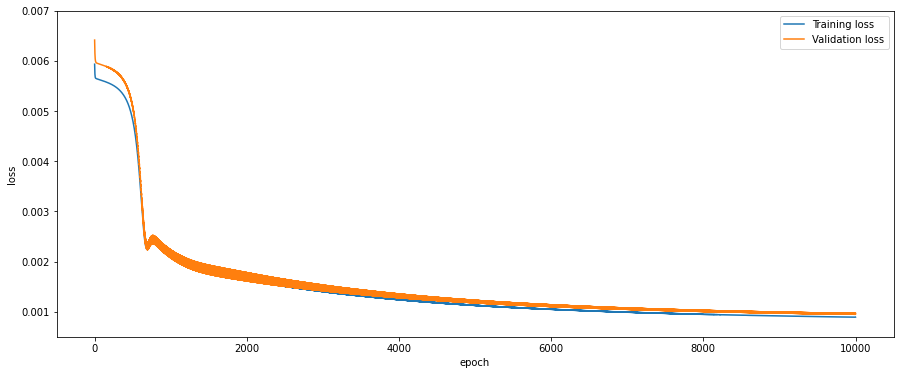

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(range(len(train_loss_list)), train_loss_list, label="Training loss")
ax.plot(range(len(val_loss_list)), val_loss_list, label="Validation loss")
ax.legend()
ax.set_ylim(0.0005, 0.007)
ax.set_xlabel(r'epoch')
ax.set_ylabel(r'loss')
plt.show()

# Prediction

In [ ]:
saver = tf.train.Saver()

with tf.Session() as session:
  saver.restore(session, "./model")
  predictions = session.run(model, feed_dict={x: x_test}) 

INFO:tensorflow:Restoring parameters from ./model


### Test MSE

In [ ]:
np.mean(np.square(t_test - predictions))

0.0007682439141978268

# Plot - predictions

INFO:tensorflow:Restoring parameters from ./model


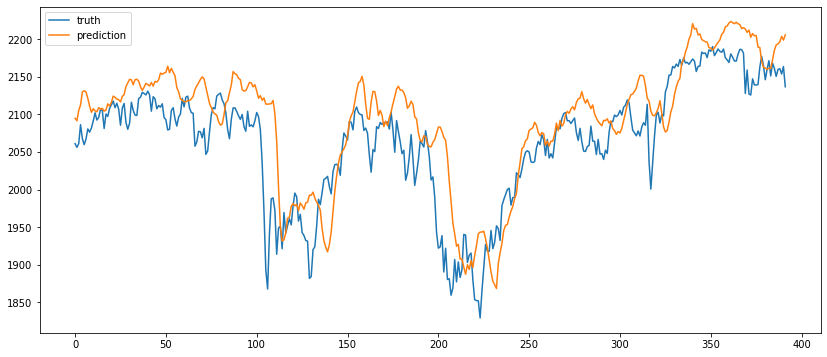

In [ ]:
def inverse_relative_change_normalization(data, norm):
  return data * norm + norm

# get sequences only for years 2015, 2016
close_price = df['Close'][df['Close'].index.to_series().between('2015-01-01', '2017-01-01')]
sequences, _ = make_sequences(close_price, 50, 7, to_numpy=True)

# get predictions
saver = tf.train.Saver()
with tf.Session() as session:
  saver.restore(session, "./model")
  predictions = session.run([model], feed_dict={x: sequences})[0]

# unnormalize predictions
norm = close_price.iloc[:-56]
predictions = inverse_relative_change_normalization(predictions.ravel(), norm)
np.savetxt('predictions_2015.csv', predictions, delimiter=',')

# make plot
fig, ax = plt.subplots(figsize=(14,6))

# 2 years range
ax.plot(np.arange(392), close_price.iloc[56:56+392], label='truth')
ax.plot(np.arange(392), predictions[:392], label='prediction')

ax.legend()

plt.show()

# Plot - trends

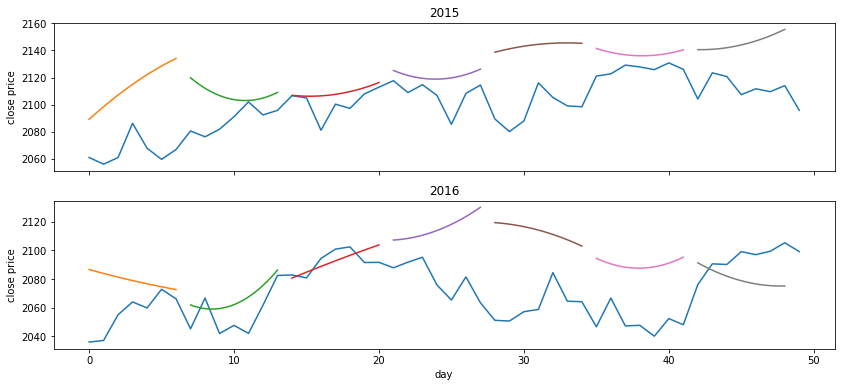

In [ ]:
close_price = df['Close'][df['Close'].index.to_series().between('2015-01-01', '2017-01-01')]

N = 50    # number of days to plot
k = 7     # length of trend to predict
polyorder = 2 # order of polynomial regression

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,6))

for ax, year in zip(axes, [2015, 2016]):
    
    truth = close_price[close_price.index.to_series().between(f'{year}-01-01', f'{year+1}-01-01')]
    ax.plot(np.arange(N), truth.iloc[56:(56+N)], label='truth')
    
    pred = predictions[predictions.index.to_series().between(f'{year}-01-01', f'{year+1}-01-01')]
    
    for i in range(k):

        x = np.arange(i*k, (i+1)*k)
        y = pred.iloc[i*k:(i+1)*k]
        
        polreg = np.poly1d(np.polyfit(x, y, polyorder))

        new_x = np.linspace(i*k, (i+1)*k-1, 100)
        
        ax.plot(new_x, polreg(new_x), label='prediction')
        
    ax.set_title(year)
    ax.set_ylabel('close price')
    
axes[1].set_xlabel('day')

plt.show()